In [77]:
include("cosmology_vars.jl")
include("nu_osc_params.jl")

using DelimitedFiles
using Plots
using Interpolations
using LaTeXStrings
using QuadGK
using SpecialFunctions;

In [2]:
function F0_tint_func(F0vec::Vector{Float64})
    es = range(0, 100, 2000)
    F0int_ne = Interpolations.interpolate((vec(es),), F0vec, Gridded(Linear()))
    return extrapolate(F0int_ne, 0.0)
end

F0s_vec = readdlm("F0s_vec.txt", comments=true)

F0_νe_270sm, F0_νebar_270sm, F0_νx_270sm = F0_tint_func(vec(F0s_vec[:, 1])), F0_tint_func(vec(F0s_vec[:, 2])), F0_tint_func(vec(F0s_vec[:, 3]))
F0_νe_112sm, F0_νebar_112sm, F0_νx_112sm = F0_tint_func(vec(F0s_vec[:, 4])), F0_tint_func(vec(F0s_vec[:, 5])), F0_tint_func(vec(F0s_vec[:, 6]))
F0_νe_bh, F0_νebar_bh, F0_νx_bh = F0_tint_func(vec(F0s_vec[:, 7])), F0_tint_func(vec(F0s_vec[:, 8])), F0_tint_func(vec(F0s_vec[:, 9]))

function F0(E, β, sm)
    if β == "e" && sm == "small"
        return F0_νe_112sm(E)
    elseif β == "e" && sm == "large"
        return F0_νe_270sm(E)
    elseif β == "e" && sm == "bh"
        return F0_νe_bh(E)
    elseif β == "ebar" && sm == "small"
        return F0_νebar_112sm(E)
    elseif β == "ebar" && sm == "large"
        return F0_νebar_270sm(E)
    elseif β == "ebar" && sm == "bh"
        return F0_νebar_bh(E)   
    elseif β == "x" && sm == "small"
        return F0_νx_112sm(E)
    elseif β == "x" && sm == "large"
        return F0_νx_270sm(E)
    elseif β == "x" && sm == "bh"
        return F0_νx_bh(E)
    else
        return 0
    end
end

# Oscillations thru the SN medium
# Accounting for oscillations thru the SN medium

s12 = 0.297
c12 = 1 - s12
PH = 0

# ordering = "NO" (normal ordering) or "IO" (inverted ordering)
function F(E, β, sm, ordering)
    if ordering == "NO"
        if β == "e"
            return F0(E, "x", sm)
        elseif β == "ebar"
            return c12*F0(E, "ebar", sm) + s12*F0(E, "x", sm)
        elseif β == "x"
            return 0.5*(F0(E, "e", sm) + F0(E, "x", sm))
        elseif β == "xbar"
            return 0.5*(s12*F0(E, "ebar", sm) + (1 + c12)*F0(E, "x", sm))
        else
            return 0
        end
    elseif ordering == "IO"
        if β == "e"
            return s12*F0(E, "e", sm) + c12*F0(E, "x", sm)
        elseif β == "ebar"
            return F0(E, "x", sm)
        elseif β == "x"
            return 0.5*(c12*F0(E, "e", sm) + (1 + s12)*F0(E, "x", sm))
        elseif β == "xbar"
            return 0.5*(F0(E, "ebar", sm) + F0(E, "x", sm))
        else
            return 0
        end
    else
        return 0
    end
end

# In the mass basis now: i = 1, 2, 3, nubar = true or false
function Fmass(E, i, sm, ordering, nubar)
    if nubar==false
        return Usqred(ordering)[1, i]*F(E, "e", sm, ordering) + (1 - Usqred(ordering)[1, i])*F(E, "x", sm, ordering)
    elseif nubar==true
        return Usqred(ordering)[1, i]*F(E, "ebar", sm, ordering) + (1 - Usqred(ordering)[1, i])*F(E, "xbar", sm, ordering)
    else
        return 0
    end
end;

In [82]:
# We can take normchoice to be SNRnorm, SNRnorm_low, or SNRnorm_high
function DSNB_integrand(E, z, i, ordering, nubar, bh_frac, normchoice)
    c0 = 3e8 # m s^(-1)
    if bh_frac == "21"
        return (c0*normchoice*SFR(z)/Hubble(z)) * (ηAD(15, 8)*Fmass(E*(1+z), i, "small", ordering, nubar) 
        + (ηAD(22, 15)+ηAD(27, 25))*Fmass(E*(1+z), i, "large", ordering, nubar) + (ηAD(25, 22)+ηAD(125, 27))*Fmass(E*(1+z), i, "bh", ordering, nubar))
    elseif bh_frac == "41"
        return (c0*normchoice*SFR(z)/Hubble(z)) * (ηAD(15, 8)*Fmass(E*(1+z), i, "small", ordering, nubar) 
        + ηAD(125, 15)*Fmass(E*(1+z), i, "bh", ordering, nubar))
    elseif bh_frac == "09"
        return (c0*normchoice*SFR(z)/Hubble(z)) * (ηAD(15, 8)*Fmass(E*(1+z), i, "small", ordering, nubar)
        + ηAD(40, 15)*Fmass(E*(1+z), i, "large", ordering, nubar) + ηAD(125, 40)*Fmass(E*(1+z), i, "bh", ordering, nubar))
    else
        return 0
    end
end

DSNBmass(E, i, ordering, nubar, bh_frac, normchoice) = 0.00208 * quadgk.(z -> DSNB_integrand.(E, z, i, ordering, nubar, bh_frac, normchoice), 0, 5, rtol=1e-3)[1]

DSNBmass_zdep(E, z0, i, ordering, nubar, bh_frac, normchoice) = 0.00208 * 1/(1+z0) * quadgk.(z -> DSNB_integrand.(E/(1+z0), z, i, ordering, nubar, bh_frac, normchoice), z0, 5, rtol=1e-3)[1];

In [454]:
DSNBmass_zdep(1, 0, 1, "NO", false, "21", SNRnorm)

0.8292585297082508

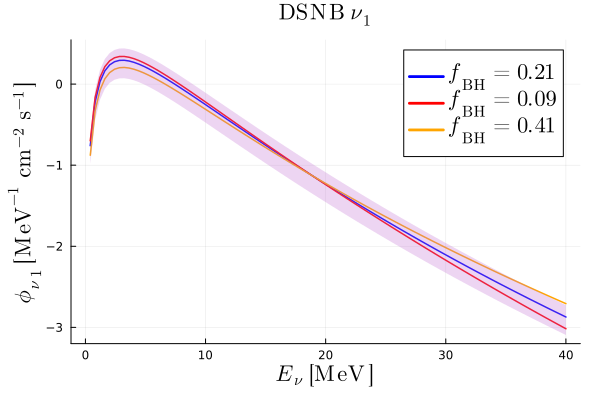

In [164]:
upribbon = DSNBmass.(es_dsnb, 1, "NO", false, "21", SNRnorm_high) .- log10.(DSNBmass.(es_dsnb, 1, "NO", false, "21", SNRnorm))

plot(
    es_dsnb,
    [log10.(DSNBmass.(es_dsnb, 1, "NO", false, "21", SNRnorm)) log10.(DSNBmass.(es_dsnb, 1, "NO", false, "09", SNRnorm)) log10.(DSNBmass.(es_dsnb, 1, "NO", false, "41", SNRnorm))],
    c=[:blue :red :orange :brown :black],
    lw=1.5,
    label=[L"f_\mathrm{BH} = 0.21" L"f_\mathrm{BH} = 0.09" L"f_\mathrm{BH} = 0.41"],
    title=L"\mathrm{DSNB~\nu_1}",
    ylabel=L"\phi_{\nu}_1~[\mathrm{MeV^{-1}~cm^{-2}~s^{-1}}]",
    xlabel=L"E_\nu~\mathrm{[MeV]}",
    xguidefontsize=15,
    yguidefontsize=15,
    titlefontsize=15,
    legendfontsize=15,
    margins=3Plots.mm
)
plot!(
    es_dsnb,
    log10.(DSNBmass.(es_dsnb, 1, "NO", false, "21", SNRnorm_low)),
    alpha=0,
    fillrange=log10.(DSNBmass.(es_dsnb, 1, "NO", false, "21", SNRnorm_high)),
    fillalpha=0.3,
    label=false
)

In [259]:
# Trying to implement decays now

# Define this effective length function
LeffIntegrand(z) = (H0*sqrt(energy_matter*(1+z)^3 + energy_dark))^(-1)*(1+z)^(-2)

leff_quadint(z0) = quadgk(z -> LeffIntegrand(z), 0, z0)[1]

zs_leff = range(0, 5, 1000)
leff_ne = Interpolations.interpolate((vec(zs_leff),), leff_quadint.(zs_leff), Gridded(Linear()))
leff = extrapolate(leff_ne, 0.0)

function decay(E, α, z)
    scalefactor = 4.68e28
    return exp(-scalefactor*α*leff(z)/E)
end

function decay_zdep(E, α, z0, z)
    scalefactor = 4.68e28
    return exp((-scalefactor*α*(leff(z)-leff(z0))*(1+z0))/E)
end

function decay_integrand(E, z, α, i, ordering, nubar, bh_frac, normchoice)
    if α == 0
        return DSNB_integrand(E, z, i, ordering, nubar, bh_frac, normchoice)
    else
        return DSNB_integrand(E, z, i, ordering, nubar, bh_frac, normchoice)*decay(E, α, z)
    end
end

function decay_integrand_zdep(E, z0, z, α, i, ordering, nubar, bh_frac, normchoice)
    if α == 0
        return DSNB_integrand(E, z, i, ordering, nubar, bh_frac, normchoice)
    else
        int = DSNB_integrand(E, z, i, ordering, nubar, bh_frac, normchoice)*decay(E, α, z)*decay(E, -α, z0)
        if isnan(int) || isinf(int)
            return 0.0
        else
            return int
        end
    end
end

function DSNB_idecay(E, α, i, ordering, nubar, bh_frac, normchoice)
    return 0.00208*quadgk(z -> decay_integrand(E, z, α, i, ordering, nubar, bh_frac, normchoice), 0, 5, rtol=1e-2)[1]
end

function DSNB_idecay_zdep(E, z0, α, i, ordering, nubar, bh_frac, normchoice)
    0.00208 * 1/(1+z0) * quadgk(z -> decay_integrand_zdep(E/(1+z0), z0, z, α, i, ordering, nubar, bh_frac, normchoice), z0, 5, rtol=1e-2)[1]
end
#=
function DSNB_idecay_fastint(E, α, i, ordering, nubar, bh_frac)
    zgrid = range(0, 5, 2000)
    dz = zgrid[2] - zgrid[1]
    return 0.00208*sum(decay_integrand.(E, zgrid, α, i, ordering, nubar, bh_frac) .* dz)
end

function DSNB_idecay_zdep_fastint(E, z0, α, i, ordering, nubar, bh_frac)
    zgrid = range(z0, 5, 2000)
    dz = zgrid[2] - zgrid[1]
    return 0.00208* 1/(1+z0) * sum(decay_integrand_zdep.(E/(1+z0), z0, zgrid, α, i, ordering, nubar, bh_frac) .* dz)
end
=#

function DSNB_idecay_flavor(E, β, α1, α2, α3, ordering, nubar, bh_frac, normchoice)
    ν1 = DSNB_idecay(E, α1, 1, ordering, nubar, bh_frac, normchoice)
    ν2 = DSNB_idecay(E, α2, 2, ordering, nubar, bh_frac, normchoice)
    ν3 = DSNB_idecay(E, α3, 3, ordering, nubar, bh_frac, normchoice)
    if β == "e"
        i = 1
    elseif β == "μ"
        i = 2
    elseif β == "τ"
        i = 3
    else
        return 0.0
    end
    return Usqred(ordering)[i, 1]*ν1 + Usqred(ordering)[i, 2]*ν2 + Usqred(ordering)[i, 3]*ν3
end
;

In [6]:
es_dsnb = range(0, 40, 100);

In [94]:
dsnb_test = DSNB_idecay.(es_dsnb, 0, 1, "NO", false, "21", SNRnorm)
dsnb_zdep_test = DSNB_idecay_zdep.(es_dsnb, 1, 0, 1, "NO", false, "21", SNRnorm)
dsnb_idecay_test = DSNB_idecay.(es_dsnb, 10^(-24), 1, "NO", false, "21", SNRnorm)
dsnb_idecay_zdep_test = DSNB_idecay_zdep.(es_dsnb, 1, 10^(-24), 1, "NO", false, "21", SNRnorm);

In [236]:
# Let's first consider an effective 2ν SH case where ν1 and ν2 are stable, so only ν3 → ν1 is allowed

# Energy spectra (hc = true or false, helicity conserving or flipping respectively)
function ψSH(Eh, El, hc)
    if hc
        return 2*El/Eh^2
    else
        return (2/Eh)*(1-(El/Eh))
    end
end

branch(j, i) = 0.5

qnorm = 3.086e19 * 1.516e15 * 1e6 / (3e8 * 1e12)

# Here we take m_j > m_i
function qcontrib(E0, z, j, jbar, i, ibar, αj, ordering, bh_frac, normchoice)

    if ordering == "NO" && j <= i
        return println("error: not kinematically allowed")
    elseif ordering == "IO" && j == 1 && i == 2
        return println("error: not kinematically allowed")
    elseif ordering == "IO" && j == 3 && i == 1
        return println("error: not kinematically allowed")
    elseif ordering == "IO" && j == 3 && i == 2
        return println("error: not kinematically allowed")
    else
        if jbar == ibar
            hc = true
        else
            hc = false
        end
        integrand(E) = (c0/Hubble(z))*DSNB_idecay_zdep(E, z, αj, j, ordering, jbar, bh_frac, normchoice) * (αj * branch(j, i)/E) * ψSH(E, E0, hc)
        E0max = E0*(1+z) + 50
        return qnorm * quadgk(E -> integrand(E), E0, E0max, rtol=1e-2)[1]
    end
end

#=
function qcontrib_old(E0, z, j, jbar, i, ibar, αj)
    if jbar == ibar
        hc = true
    else
        hc = false
    end
    integrand(E) = (c0/Hubble(z))*DSNB_idecay_zdep(E, z, αj, j, "NO", jbar, "21", SNRnorm) * (αj * branch(j, i)/E) * ψSH(E, E0, hc)
    E0max = E0*(1+z) + 50
    return qnorm * quadgk(E -> integrand(E), E0, E0max, rtol=1e-2)[1]
end
=#

#=
function qcontrib_fastint(E0, z, j, jbar, i, ibar, αj)
    if jbar == ibar
        hc = true
    else
        hc = false
    end
    integrand(E) = (c0/Hubble(z))*DSNB_idecay_zdep_fastint(E, z, αj, j, "NO", jbar, "21") * (αj * branch(j, i)/E) * ψSH(E, E0, hc)
    es_int = range(E0, 50, 1000)
    de = es_int[2] - es_int[1]
    return qnorm * sum(de * integrand.(es_int))
end
=#
;

In [421]:
intψ(E0, hc) = quadgk(E -> DSNB_idecay(E, 0, 3, "NO", false, "21", SNRnorm)*ψSH(E, E0, hc)/E, E0, E0+1000, rtol=1e-3)[1];

In [432]:
intψ(1, true)

1.6705870262715097

In [490]:
function DSNB_vdecay(E, αj, i, ibar, ordering, bh_frac, normchoice)
    if ordering == "NO" && i == 3
        return DSNB_idecay(E, αj, i, "NO", ibar, bh_frac, normchoice)
    elseif ordering == "IO" && i == 2
        return DSNB_idecay(E, αj, i, "IO", ibar, bh_frac, normchoice)
    else
        # Here, for NO we take ν2 to be stable and for IO we take ν1 to be stable, and we take the lightest mass states to be stable as well
        if ordering == "NO"
            qint = quadgk(z -> (qcontrib(E*(1+z), z, 3, false, i, ibar, αj, "NO", bh_frac, normchoice)+qcontrib(E*(1+z), z, 3, true, i, ibar, αj, "NO", bh_frac, normchoice)), 0, 5, rtol=1e-2)[1]
        elseif ordering == "IO"
            qint = quadgk(z -> (qcontrib(E*(1+z), z, 2, false, i, ibar, αj, "IO", bh_frac, normchoice)+qcontrib(E*(1+z), z, 2, true, i, ibar, αj, "IO", bh_frac, normchoice)), 0, 5, rtol=1e-2)[1]
        else
            return println("error: ordering takes either 'NO' or 'IO'")
        end
        return DSNB_idecay(E, 0, i, ordering, ibar, bh_frac, normchoice) + qint
    end
end;

# Other few cases where the heaviest mass state and lightest mass state are stable, and the middle mass state decays into the lightest mass state
function DSNB_vdecay_alt(E, αj, i, ibar, ordering, bh_frac, normchoice)
    if ordering == "NO" && i == 2
        return DSNB_idecay(E, αj, i, "NO", ibar, bh_frac, normchoice)
    elseif ordering == "IO" && i == 1
        return DSNB_idecay(E, αj, i, "IO", ibar, bh_frac, normchoice)
    elseif ordering == "NO" && i == 3
        return DSNB_idecay(E, 0, i, "NO", ibar, bh_frac, normchoice)
    elseif ordering == "IO" && i == 2
        return DSNB_idecay(E, 0, i, "IO", ibar, bh_frac, normchoice)
    else
        # Here, for NO we take ν2 to be stable and for IO we take ν1 to be stable, and we take the lightest mass states to be stable as well
        if ordering == "NO"
            qint = quadgk(z -> (qcontrib(E*(1+z), z, 2, false, i, ibar, αj, "NO", bh_frac, normchoice)+qcontrib(E*(1+z), z, 2, true, i, ibar, αj, "NO", bh_frac, normchoice)), 0, 5, rtol=1e-2)[1]
        elseif ordering == "IO"
            qint = quadgk(z -> (qcontrib(E*(1+z), z, 1, false, i, ibar, αj, "IO", bh_frac, normchoice)+qcontrib(E*(1+z), z, 1, true, i, ibar, αj, "IO", bh_frac, normchoice)), 0, 5, rtol=1e-2)[1]
        else
            return println("error: ordering takes either 'NO' or 'IO'")
        end
        return DSNB_idecay(E, 0, i, ordering, ibar, bh_frac, normchoice) + qint
    end
end;

In [ ]:
#=
integrand(E) = (c0/Hubble(z))*DSNB_idecay_zdep(E, z, αj, j, ordering, jbar, bh_frac, normchoice) * (αj * branch(j, i)/E) * ψSH(E, E0, hc)
E0max = E0*(1+z) + 50
return qnorm * quadgk(E -> integrand(E), E0, E0max, rtol=1e-2)[1]

function branch_3ν(j, i, ordering)
    if ordering == "NO"
        if j == 3
            return 0.25
        elseif j == 2
            return 0.5
        else
            return println("error: j is not a valid index")
        end
    elseif ordering == "IO"
        if j == 2
            return 0.25
        elseif j == 1
            return 0.5
        else
            return println("error: j is not a valid index")
        end
    else
        return println("error: ordering must be either 'NO' or 'IO'")
    end
end


function qcontrib_zdep(E0, z, j, jbar, i, ibar, αh, ordering, bh_frac, normchoice)
    if jbar == ibar
        hc = true
    else
        hc = false
    end
    if ordering == "NO"
        if i == 2
            integrand(E) = (c0/Hubble(z))*DSNB_idecay_zdep(E0, z, αh, i, "NO", ibar, bh_frac, normchoice) * (αh * branch_3ν(j, i, "NO")/E) * ψSH(E, E0, hc)
            E0max = E0 + 50
            return qnorm * quadgk(E -> integrand(E), E0, Emax, rtol=1e-2)[1]
        elseif i == 1




function DSNB_vdecay_zdep(E, z0, αh, i, ibar, ordering, bh_frac, normchoice)
    if ordering == "NO"
        if i == 3
            return DSNB_idecay_zdep(E, z0, αh, i, "NO", ibar, bh_frac, normchoice)
        elseif 


DSNB_idecay_zdep_NO_3(E, z0, α3, nubar, bh_frac, normchoice) = DSNB_idecay_zdep(E, z, α3, 3, "NO", nubar, bh_frac, normchoice)
function DSNB_vdecay_zdep_NO_2(E0, z0, α3, α2, 3bar, 2bar, bh_frac, normchoice)

    regular_integrand(E, z) = 0.00208 * DSNB_integrand(E, z, 2, "NO", 2bar, bh_frac, normchoice)
    qcontrib_integrand(E, Eprime, z, nubar) = qnorm*(c0/Hubble(z))*DSNB_idecay_zdep_NO_3(Eprime, z, α3, nubar, bh_frac, normchoice) * (α3 * branch_3ν(3, 2, "NO")/E) * ψSH(Eprime, E, hc)
    qcontribs(E, z) = quadgk(Eprime -> qcontrib_integrand(Eprime, z, false)+qcontrib_integrand(Eprime, z, true), E, E+50, rtol=1e-2)[1]

    zintegrand(z) = regular_integrand(E0*(1+z)/(1+z0, z)

=#

In [377]:
function total_nus(α, daughter, ordering, bh_frac, normchoice)
    if ordering == "NO"
        if daughter == 1
            α1, α2, α3 = α, 0.0, α
        elseif daughter == 2
            α1, α2, α3 = 0.0, α, α
        else
            return println("error: for NO, 'daughter' must be either ν1 or ν2")
        end
    elseif ordering == "IO"
        if daughter == 3
            α3, α1, α2 = α, 0.0, α
        elseif daughter == 1
            α3, α1, α2 = 0.0, α, α
        else
            return println("error: for IO, 'daughter' must be either ν1 or ν3")
        end
    else
        return println("error: ordering must take either 'NO' or 'IO'")
    end
    ν3 = quadgk(E -> DSNB_vdecay(E, α3, 3, false, ordering, bh_frac, normchoice), 0, 100, rtol=1e-3)[1]
    ν2 = quadgk(E -> DSNB_vdecay(E, α2, 2, false, ordering, bh_frac, normchoice), 0, 100, rtol=1e-3)[1]
    ν1 = quadgk(E -> DSNB_vdecay(E, α1, 1, false, ordering, bh_frac, normchoice), 0, 100, rtol=1e-3)[1]
    ν3bar = quadgk(E -> DSNB_vdecay(E, α3, 3, true, ordering, bh_frac, normchoice), 0, 100, rtol=1e-3)[1]
    ν2bar = quadgk(E -> DSNB_vdecay(E, α2, 2, true, ordering, bh_frac, normchoice), 0, 100, rtol=1e-3)[1]
    ν1bar = quadgk(E -> DSNB_vdecay(E, α1, 1, true, ordering, bh_frac, normchoice), 0, 100, rtol=1e-3)[1]
    return ν1 + ν2 + ν3 + ν1bar + ν2bar + ν3bar
end

total_nus (generic function with 2 methods)

In [479]:
# daughter specifies the state the heaviest mass state decays into in our 2ν framework

function DSNB_vdecay_νe(E, α, daughter, ebar, ordering, bh_frac, normchoice)
    if ordering == "NO"
        if daughter == 1
            α1, α2, α3 = α, 0.0, α
        elseif daughter == 2
            α1, α2, α3 = 0.0, α, α
        else
            return println("error: for NO, 'daughter' must be either ν1 or ν2")
        end
    elseif ordering == "IO"
        if daughter == 3
            α3, α1, α2 = α, 0.0, α
        elseif daughter == 1
            α3, α1, α2 = 0.0, α, α
        else
            return println("error: for IO, 'daughter' must be either ν1 or ν3")
        end
    else
        return println("error: ordering must take either 'NO' or 'IO'")
    end
    ν3 = DSNB_vdecay(E, α3, 3, ebar, ordering, bh_frac, normchoice)
    ν2 = DSNB_vdecay(E, α2, 2, ebar, ordering, bh_frac, normchoice)
    ν1 = DSNB_vdecay(E, α1, 1, ebar, ordering, bh_frac, normchoice)
    return Usqred("NO")[1, 1]*ν1 + Usqred("NO")[1, 2]*ν2 + Usqred("NO")[1, 3]*ν3
end

function DSNB_vdecay_νe_alt(E, α, ebar, ordering, bh_frac, normchoice)
    if ordering == "NO"
        α1, α2, α3 = α, α, 0.0
    elseif ordering == "IO"
        α1, α2, α3 = α, 0.0, α
    else
        return println("error: ordering must take either 'NO' or 'IO'")
    end
    ν3 = DSNB_vdecay_alt(E, α3, 3, ebar, ordering, bh_frac, normchoice)
    ν2 = DSNB_vdecay_alt(E, α2, 2, ebar, ordering, bh_frac, normchoice)
    ν1 = DSNB_vdecay_alt(E, α1, 1, ebar, ordering, bh_frac, normchoice)
    return Usqred("NO")[1, 1]*ν1 + Usqred("NO")[1, 2]*ν2 + Usqred("NO")[1, 3]*ν3
end

DSNB_vdecay_νe_alt (generic function with 1 method)

In [313]:
dsnb_νe_nodecay_NO = DSNB_idecay_flavor.(es_dsnb_test, "e", 0, 0, 0, "NO", true, "21", SNRnorm)
dsnb_νe_nodecay_IO = DSNB_idecay_flavor.(es_dsnb_test, "e", 0, 0, 0, "IO", true, "21", SNRnorm);

In [458]:
dsnb_νe_nodecay_NO_f41 = DSNB_idecay_flavor.(es_dsnb_test, "e", 0, 0, 0, "NO", true, "41", SNRnorm)
dsnb_νe_nodecay_IO_f41 = DSNB_idecay_flavor.(es_dsnb_test, "e", 0, 0, 0, "IO", true, "41", SNRnorm)
dsnb_νe_nodecay_NO_f09 = DSNB_idecay_flavor.(es_dsnb_test, "e", 0, 0, 0, "NO", true, "09", SNRnorm)
dsnb_νe_nodecay_IO_f09 = DSNB_idecay_flavor.(es_dsnb_test, "e", 0, 0, 0, "IO", true, "09", SNRnorm);

In [476]:
dsnb_νe_vdecay_26_NO_daughter1_f21 = DSNB_vdecay_νe.(es_dsnb_test, 10^(-26), 1, true, "NO", "21", SNRnorm)
dsnb_νe_vdecay_26_NO_daughter2_f21 = DSNB_vdecay_νe.(es_dsnb_test, 10^(-26), 2, true, "NO", "21", SNRnorm)
dsnb_νe_vdecay_26_NO_daughter1_f41 = DSNB_vdecay_νe.(es_dsnb_test, 10^(-26), 1, true, "NO", "41", SNRnorm)
dsnb_νe_vdecay_26_NO_daughter2_f41 = DSNB_vdecay_νe.(es_dsnb_test, 10^(-26), 2, true, "NO", "41", SNRnorm)
dsnb_νe_vdecay_26_NO_daughter1_f09 = DSNB_vdecay_νe.(es_dsnb_test, 10^(-26), 1, true, "NO", "09", SNRnorm)
dsnb_νe_vdecay_26_NO_daughter2_f09 = DSNB_vdecay_νe.(es_dsnb_test, 10^(-26), 2, true, "NO", "09", SNRnorm)

dsnb_νe_vdecay_26_IO_daughter1_f21 = DSNB_vdecay_νe.(es_dsnb_test, 10^(-26), 1, true, "IO", "21", SNRnorm)
dsnb_νe_vdecay_26_IO_daughter3_f21 = DSNB_vdecay_νe.(es_dsnb_test, 10^(-26), 3, true, "IO", "21", SNRnorm)
dsnb_νe_vdecay_26_IO_daughter1_f41 = DSNB_vdecay_νe.(es_dsnb_test, 10^(-26), 1, true, "IO", "41", SNRnorm)
dsnb_νe_vdecay_26_IO_daughter3_f41 = DSNB_vdecay_νe.(es_dsnb_test, 10^(-26), 3, true, "IO", "41", SNRnorm)
dsnb_νe_vdecay_26_IO_daughter1_f09 = DSNB_vdecay_νe.(es_dsnb_test, 10^(-26), 1, true, "IO", "09", SNRnorm)
dsnb_νe_vdecay_26_IO_daughter3_f09 = DSNB_vdecay_νe.(es_dsnb_test, 10^(-26), 3, true, "IO", "09", SNRnorm);

In [307]:
dsnb_νe_vdecay_25_NO_daughter1_f21 = DSNB_vdecay_νe.(es_dsnb_test, 10^(-25), 1, true, "NO", "21", SNRnorm)
dsnb_νe_vdecay_25_NO_daughter2_f21 = DSNB_vdecay_νe.(es_dsnb_test, 10^(-25), 2, true, "NO", "21", SNRnorm)
dsnb_νe_vdecay_25_NO_daughter1_f41 = DSNB_vdecay_νe.(es_dsnb_test, 10^(-25), 1, true, "NO", "41", SNRnorm)
dsnb_νe_vdecay_25_NO_daughter2_f41 = DSNB_vdecay_νe.(es_dsnb_test, 10^(-25), 2, true, "NO", "41", SNRnorm)
dsnb_νe_vdecay_25_NO_daughter1_f09 = DSNB_vdecay_νe.(es_dsnb_test, 10^(-25), 1, true, "NO", "09", SNRnorm)
dsnb_νe_vdecay_25_NO_daughter2_f09 = DSNB_vdecay_νe.(es_dsnb_test, 10^(-25), 2, true, "NO", "09", SNRnorm)

dsnb_νe_vdecay_25_IO_daughter1_f21 = DSNB_vdecay_νe.(es_dsnb_test, 10^(-25), 1, true, "IO", "21", SNRnorm)
dsnb_νe_vdecay_25_IO_daughter3_f21 = DSNB_vdecay_νe.(es_dsnb_test, 10^(-25), 3, true, "IO", "21", SNRnorm)
dsnb_νe_vdecay_25_IO_daughter1_f41 = DSNB_vdecay_νe.(es_dsnb_test, 10^(-25), 1, true, "IO", "41", SNRnorm)
dsnb_νe_vdecay_25_IO_daughter3_f41 = DSNB_vdecay_νe.(es_dsnb_test, 10^(-25), 3, true, "IO", "41", SNRnorm)
dsnb_νe_vdecay_25_IO_daughter1_f09 = DSNB_vdecay_νe.(es_dsnb_test, 10^(-25), 1, true, "IO", "09", SNRnorm)
dsnb_νe_vdecay_25_IO_daughter3_f09 = DSNB_vdecay_νe.(es_dsnb_test, 10^(-25), 3, true, "IO", "09", SNRnorm);

In [455]:
dsnb_νe_vdecay_24_NO_daughter1_f21 = DSNB_vdecay_νe.(es_dsnb_test, 10^(-24), 1, true, "NO", "21", SNRnorm)
dsnb_νe_vdecay_24_NO_daughter2_f21 = DSNB_vdecay_νe.(es_dsnb_test, 10^(-24), 2, true, "NO", "21", SNRnorm)
dsnb_νe_vdecay_24_NO_daughter1_f41 = DSNB_vdecay_νe.(es_dsnb_test, 10^(-24), 1, true, "NO", "41", SNRnorm)
dsnb_νe_vdecay_24_NO_daughter2_f41 = DSNB_vdecay_νe.(es_dsnb_test, 10^(-24), 2, true, "NO", "41", SNRnorm)
dsnb_νe_vdecay_24_NO_daughter1_f09 = DSNB_vdecay_νe.(es_dsnb_test, 10^(-24), 1, true, "NO", "09", SNRnorm)
dsnb_νe_vdecay_24_NO_daughter2_f09 = DSNB_vdecay_νe.(es_dsnb_test, 10^(-24), 2, true, "NO", "09", SNRnorm)

dsnb_νe_vdecay_24_IO_daughter1_f21 = DSNB_vdecay_νe.(es_dsnb_test, 10^(-24), 1, true, "IO", "21", SNRnorm)
dsnb_νe_vdecay_24_IO_daughter3_f21 = DSNB_vdecay_νe.(es_dsnb_test, 10^(-24), 3, true, "IO", "21", SNRnorm)
dsnb_νe_vdecay_24_IO_daughter1_f41 = DSNB_vdecay_νe.(es_dsnb_test, 10^(-24), 1, true, "IO", "41", SNRnorm)
dsnb_νe_vdecay_24_IO_daughter3_f41 = DSNB_vdecay_νe.(es_dsnb_test, 10^(-24), 3, true, "IO", "41", SNRnorm)
dsnb_νe_vdecay_24_IO_daughter1_f09 = DSNB_vdecay_νe.(es_dsnb_test, 10^(-24), 1, true, "IO", "09", SNRnorm)
dsnb_νe_vdecay_24_IO_daughter3_f09 = DSNB_vdecay_νe.(es_dsnb_test, 10^(-24), 3, true, "IO", "09", SNRnorm);

In [480]:
dsnb_νe_vdecay_alt_26_NO_f21 = DSNB_vdecay_νe_alt.(es_dsnb_test, 10^(-26), true, "NO", "21", SNRnorm)
dsnb_νe_vdecay_alt_26_NO_f41 = DSNB_vdecay_νe_alt.(es_dsnb_test, 10^(-26), true, "NO", "41", SNRnorm)
dsnb_νe_vdecay_alt_26_NO_f09 = DSNB_vdecay_νe_alt.(es_dsnb_test, 10^(-26), true, "NO", "09", SNRnorm)

dsnb_νe_vdecay_alt_26_IO_f21 = DSNB_vdecay_νe_alt.(es_dsnb_test, 10^(-26), true, "IO", "21", SNRnorm)
dsnb_νe_vdecay_alt_26_IO_f41 = DSNB_vdecay_νe_alt.(es_dsnb_test, 10^(-26), true, "IO", "41", SNRnorm)
dsnb_νe_vdecay_alt_26_IO_f09 = DSNB_vdecay_νe_alt.(es_dsnb_test, 10^(-26), true, "IO", "09", SNRnorm)

dsnb_νe_vdecay_alt_25_NO_f21 = DSNB_vdecay_νe_alt.(es_dsnb_test, 10^(-25), true, "NO", "21", SNRnorm)
dsnb_νe_vdecay_alt_25_NO_f41 = DSNB_vdecay_νe_alt.(es_dsnb_test, 10^(-25), true, "NO", "41", SNRnorm)
dsnb_νe_vdecay_alt_25_NO_f09 = DSNB_vdecay_νe_alt.(es_dsnb_test, 10^(-25), true, "NO", "09", SNRnorm)

dsnb_νe_vdecay_alt_25_IO_f21 = DSNB_vdecay_νe_alt.(es_dsnb_test, 10^(-25), true, "IO", "21", SNRnorm)
dsnb_νe_vdecay_alt_25_IO_f41 = DSNB_vdecay_νe_alt.(es_dsnb_test, 10^(-25), true, "IO", "41", SNRnorm)
dsnb_νe_vdecay_alt_25_IO_f09 = DSNB_vdecay_νe_alt.(es_dsnb_test, 10^(-25), true, "IO", "09", SNRnorm)

dsnb_νe_vdecay_alt_24_NO_f21 = DSNB_vdecay_νe_alt.(es_dsnb_test, 10^(-24), true, "NO", "21", SNRnorm)
dsnb_νe_vdecay_alt_24_NO_f41 = DSNB_vdecay_νe_alt.(es_dsnb_test, 10^(-24), true, "NO", "41", SNRnorm)
dsnb_νe_vdecay_alt_24_NO_f09 = DSNB_vdecay_νe_alt.(es_dsnb_test, 10^(-24), true, "NO", "09", SNRnorm)

dsnb_νe_vdecay_alt_24_IO_f21 = DSNB_vdecay_νe_alt.(es_dsnb_test, 10^(-24), true, "IO", "21", SNRnorm)
dsnb_νe_vdecay_alt_24_IO_f41 = DSNB_vdecay_νe_alt.(es_dsnb_test, 10^(-24), true, "IO", "41", SNRnorm)
dsnb_νe_vdecay_alt_24_IO_f09 = DSNB_vdecay_νe_alt.(es_dsnb_test, 10^(-24), true, "IO", "09", SNRnorm);

In [314]:
dsnb_nodecay_1_low, dsnb_nodecay_1_high = DSNB_idecay.(es_dsnb_test, 0, 1, "NO", true, "21", SNRnorm_low), DSNB_idecay.(es_dsnb_test, 0, 1, "NO", true, "21", SNRnorm_high)
dsnb_nodecay_ebar_NO_low, dsnb_nodecay_ebar_NO_high = DSNB_idecay_flavor.(es_dsnb_test, "e", 0, 0, 0, "NO", true, "21", SNRnorm_low), DSNB_idecay_flavor.(es_dsnb_test, "e", 0, 0, 0, "NO", true, "21", SNRnorm_high)
dsnb_nodecay_ebar_IO_low, dsnb_nodecay_ebar_IO_high = DSNB_idecay_flavor.(es_dsnb_test, "e", 0, 0, 0, "IO", true, "21", SNRnorm_low), DSNB_idecay_flavor.(es_dsnb_test, "e", 0, 0, 0, "IO", true, "21", SNRnorm_high)
;

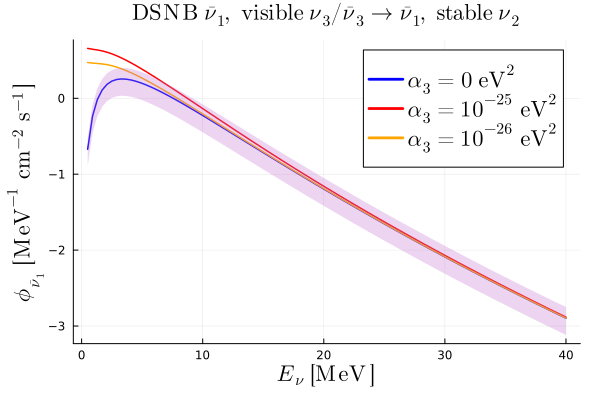

In [210]:
plot(es_dsnb_test, 
    [log10.(dsnb_nodecay_1) log10.(dsnb_vdecay_test_25) log10.(dsnb_vdecay_test_26)],
    c=[:blue :red :orange :brown :black],
    lw=1.5,
    ls=[:solid :solid :solid],
    label=[L"\alpha_3 = 0~\mathrm{eV^2}" L"\alpha_3 = 10^{-25}~\mathrm{eV^2}" L"\alpha_3 = 10^{-26}~\mathrm{eV^2}"],
    title=L"\mathrm{DSNB~\bar{\nu}_1,~visible~\nu_3/\bar{ν}_3 \to \bar{\nu}_1,~stable~\nu_2}",
    ylabel=L"\phi_{\bar{\nu}_1}~[\mathrm{MeV^{-1}~cm^{-2}~s^{-1}}]",
    xlabel=L"E_\nu~\mathrm{[MeV]}",
    xguidefontsize=15,
    yguidefontsize=15,
    titlefontsize=15,
    legendfontsize=15,
    margins=3Plots.mm
)
plot!(es_dsnb_test,
    log10.(dsnb_nodecay_1_low),
    alpha=0,
    fillrange=log10.(dsnb_nodecay_1_high),
    fillalpha=0.3,
    label=false
)

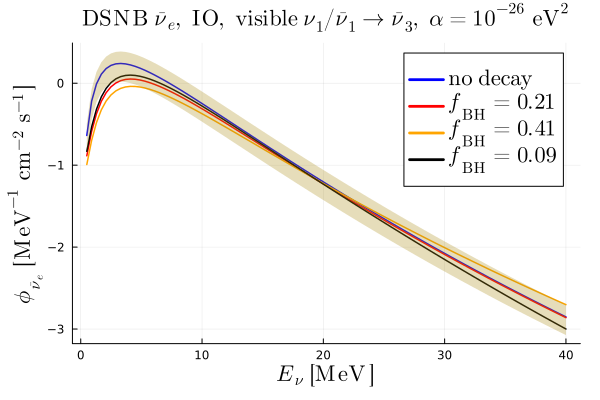

In [500]:
plot(
    es_dsnb_test,
    [log10.(dsnb_νe_nodecay_IO) log10.(dsnb_νe_vdecay_alt_26_IO_f21) log10.(dsnb_νe_vdecay_alt_26_IO_f41) log10.(dsnb_νe_vdecay_alt_26_IO_f09)],
    c=[:blue :red :orange :black],
    lw=1.5,
    ls=[:solid :solid :solid],
    label=[L"\mathrm{no~decay}" L"f_\mathrm{BH} = 0.21" L"f_\mathrm{BH} = 0.41" L"f_\mathrm{BH} = 0.09"],
    title=L"\mathrm{DSNB}~\bar{\nu}_e,\mathrm{~IO,~visible~\nu_1/\bar{\nu}_1 \to \bar{\nu}_3,~\alpha = 10^{-26}~eV^2}",
    ylabel=L"\phi_{\bar{\nu}_e}~[\mathrm{MeV^{-1}~cm^{-2}~s^{-1}}]",
    xlabel=L"E_\nu~\mathrm{[MeV]}",
    xguidefontsize=15,
    yguidefontsize=15,
    titlefontsize=15,
    legendfontsize=15,
    margins=3Plots.mm
)
plot!(es_dsnb_test,
    log10.(dsnb_nodecay_ebar_IO_low),
    alpha=0,
    fillrange=log10.(dsnb_nodecay_ebar_IO_high),
    fillalpha=0.3,
    label=false
)

In [502]:
# Detector stuff now

# Energy resolution
function δ(Ee, experiment, channel)
    if experiment == "HK"
        if channel == "IBD"
            return 0.1*sqrt(Ee)
        elseif channel == "ES"
            return 0.0349*Ee + 0.376*sqrt(Ee) - 0.123
        else
            return println("error")
        end
    else
        return println("error")
    end
end

ϵIBD = 0.67
NtIBD = 2.5e34
Δ = mass_neutron - mass_proton

# Response function
K(u, v, experiment, channel) = (1/(δ(v, experiment, channel)*sqrt(2*π)))*exp(-((u-v)/(δ(v, experiment, channel)*sqrt(2)))^2)
σIBD(Eν) = 10^(-43) * sqrt((Eν - Δ)^2 - mass_e^2)*(Eν - Δ)*Eν^(-0.07056 + 0.02018*log(Eν) - 0.001953*(log(Eν)^3))

function expnew(x)
    if exp(x) == Inf
        return 1e30
    else
        return exp(x)
    end
end

# Antiderivative wrt v (which is e_reco)
antiKIBD(u, v) = 0.5*(1 - erf((5*sqrt(2)*(u-v))/sqrt(v)) + expnew(200*u)*(erf((5*sqrt(2)*(u+v))/sqrt(v)) - 1))

binint_KIBD(Eetrue, Eereco_min, Eereco_max) = antiKIBD(Eetrue, Eereco_max) - antiKIBD(Eetrue, Eereco_min)


# Just focusing on ν3 decay rn
function diff_event_rate_IBD(Ee, decay, α, daughter, ordering, bh_frac, normchoice)
    Eν = Ee + Δ
    if decay == "none"
        return ϵIBD * NtIBD * σIBD(Eν) * DSNB_idecay_flavor(Eν, "e", 0, 0, 0, ordering, true, bh_frac, normchoice)
    elseif decay == "invisible"
        return ϵIBD * NtIBD * σIBD(Eν) * DSNB_idecay_flavor(Eν, "e", α, α, α, ordering, true, bh_frac, normchoice)
    elseif decay == "visible"
        return ϵIBD * NtIBD * σIBD(Eν) * DSNB_vdecay_νe(Eν, α, daughter, true, ordering, bh_frac, normchoice)
    else
        return 0.0
    end
end

function diff_event_rate_IBD_alt(Ee, α, ordering, bh_frac, normchoice)
    Eν = Ee + Δ
    return ϵIBD * NtIBD * σIBD(Eν) * DSNB_vdecay_νe_alt(Eν, α, true, ordering, bh_frac, normchoice)
end

event_rate_IBD_noeres(Ee_min, Ee_max) = 525600 * 60 * 20 * quadgk(Ee -> diff_event_rate_IBD(Ee), Ee_min, Ee_max)[1]

function event_rate_IBD(Ee_min, Ee_max, decay, α, daughter, ordering, bh_frac, normchoice)
    min_etrue, max_etrue = maximum([0, (Ee_min - 4*0.1*sqrt(Ee_min))]), Ee_max + 4*0.1*sqrt(Ee_max)
    return 525600 * 60 * 20 * quadgk(Eetrue -> diff_event_rate_IBD(Eetrue, decay, α, daughter, ordering, bh_frac, normchoice)*binint_KIBD(Eetrue, Ee_min, Ee_max), min_etrue, max_etrue, rtol=1e-3)[1]
end
function event_rate_IBD_alt(Ee_min, Ee_max, α, ordering, bh_frac, normchoice)
    min_etrue, max_etrue = maximum([0, (Ee_min - 4*0.1*sqrt(Ee_min))]), Ee_max + 4*0.1*sqrt(Ee_max)
    return 525600 * 60 * 20 * quadgk(Eetrue -> diff_event_rate_IBD_alt(Eetrue, α, ordering, bh_frac, normchoice)*binint_KIBD(Eetrue, Ee_min, Ee_max), min_etrue, max_etrue, rtol=1e-3)[1]
end

event_rate_IBD_alt (generic function with 1 method)

In [444]:
es_grid_min = 12:2:32
es_grid_max = es_grid_min .+ 2

events_HKIBD_nodecay_NO = event_rate_IBD.(es_grid_min, es_grid_max, "none", 10^(-25), 1, "NO", "21", SNRnorm)
events_HKIBD_nodecay_NO_low = event_rate_IBD.(es_grid_min, es_grid_max, "none", 10^(-25), 1, "NO", "21", SNRnorm_low)
events_HKIBD_nodecay_NO_high = event_rate_IBD.(es_grid_min, es_grid_max, "none", 10^(-25), 1, "NO", "21", SNRnorm_high)

events_HKIBD_nodecay_IO = event_rate_IBD.(es_grid_min, es_grid_max, "none", 10^(-25), 1, "IO", "21", SNRnorm)
events_HKIBD_nodecay_IO_low = event_rate_IBD.(es_grid_min, es_grid_max, "none", 10^(-25), 1, "IO", "21", SNRnorm_low)
events_HKIBD_nodecay_IO_high = event_rate_IBD.(es_grid_min, es_grid_max, "none", 10^(-25), 1, "IO", "21", SNRnorm_high)
;

In [447]:
events_HKIBD_vdecay_25_NO_daughter1_f21 = event_rate_IBD.(es_grid_min, es_grid_max, "visible", 10^(-25), 1, "NO", "21", SNRnorm)
events_HKIBD_vdecay_25_NO_daughter2_f21 = event_rate_IBD.(es_grid_min, es_grid_max, "visible", 10^(-25), 2, "NO", "21", SNRnorm)
events_HKIBD_vdecay_25_NO_daughter1_f41 = event_rate_IBD.(es_grid_min, es_grid_max, "visible", 10^(-25), 1, "NO", "41", SNRnorm)
events_HKIBD_vdecay_25_NO_daughter2_f41 = event_rate_IBD.(es_grid_min, es_grid_max, "visible", 10^(-25), 2, "NO", "41", SNRnorm)
;

In [503]:
events_HKIBD_vdecay_25_NO_daughter1_f09 = event_rate_IBD.(es_grid_min, es_grid_max, "visible", 10^(-25), 1, "NO", "09", SNRnorm)
events_HKIBD_vdecay_25_NO_daughter2_f09 = event_rate_IBD.(es_grid_min, es_grid_max, "visible", 10^(-25), 2, "NO", "09", SNRnorm);

In [506]:
events_HKIBD_vdecay_25_NO_alt_f21 = event_rate_IBD_alt.(es_grid_min, es_grid_max, 10^(-25), "NO", "21", SNRnorm)
events_HKIBD_vdecay_25_NO_alt_f41 = event_rate_IBD_alt.(es_grid_min, es_grid_max, 10^(-25), "NO", "41", SNRnorm)
events_HKIBD_vdecay_25_NO_alt_f09 = event_rate_IBD_alt.(es_grid_min, es_grid_max, 10^(-25), "NO", "09", SNRnorm);

In [448]:
events_HKIBD_vdecay_25_IO_daughter1_f21 = event_rate_IBD.(es_grid_min, es_grid_max, "visible", 10^(-25), 1, "IO", "21", SNRnorm)
events_HKIBD_vdecay_25_IO_daughter3_f21 = event_rate_IBD.(es_grid_min, es_grid_max, "visible", 10^(-25), 3, "IO", "21", SNRnorm)
events_HKIBD_vdecay_25_IO_daughter1_f41 = event_rate_IBD.(es_grid_min, es_grid_max, "visible", 10^(-25), 1, "IO", "41", SNRnorm)
events_HKIBD_vdecay_25_IO_daughter3_f41 = event_rate_IBD.(es_grid_min, es_grid_max, "visible", 10^(-25), 3, "IO", "41", SNRnorm)
;

In [504]:
events_HKIBD_vdecay_25_IO_daughter1_f09 = event_rate_IBD.(es_grid_min, es_grid_max, "visible", 10^(-25), 1, "IO", "09", SNRnorm)
events_HKIBD_vdecay_25_IO_daughter3_f09 = event_rate_IBD.(es_grid_min, es_grid_max, "visible", 10^(-25), 3, "IO", "09", SNRnorm);

In [507]:
events_HKIBD_vdecay_25_IO_alt_f21 = event_rate_IBD_alt.(es_grid_min, es_grid_max, 10^(-25), "IO", "21", SNRnorm)
events_HKIBD_vdecay_25_IO_alt_f41 = event_rate_IBD_alt.(es_grid_min, es_grid_max, 10^(-25), "IO", "41", SNRnorm)
events_HKIBD_vdecay_25_IO_alt_f09 = event_rate_IBD_alt.(es_grid_min, es_grid_max, 10^(-25), "IO", "09", SNRnorm);

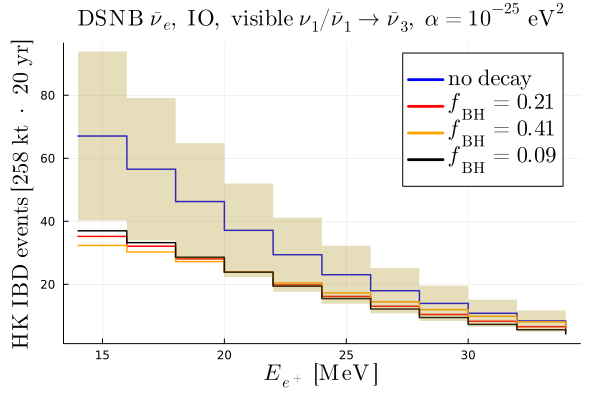

In [517]:
plot(es_grid_max,
     [events_HKIBD_nodecay_IO events_HKIBD_vdecay_25_IO_alt_f21 events_HKIBD_vdecay_25_IO_alt_f41 events_HKIBD_vdecay_25_IO_alt_f09],
     seriestype=:step,
     c=[:blue :red :orange :black],
     lw=1.5,
     ls=[:solid :solid :solid],
     label=[L"\mathrm{no~decay}" L"f_\mathrm{BH} = 0.21" L"f_\mathrm{BH} = 0.41" L"f_\mathrm{BH} = 0.09"],
     title=L"\mathrm{DSNB~}\bar{\nu}_e,~\mathrm{IO,~visible~\nu_1/\bar{\nu}_1 \to \bar{\nu}_3,~\alpha = 10^{-25}~eV^2}",
     ylabel=L"\mathrm{HK~IBD~events}~[\mathrm{258~kt~\cdot~20~yr}]",
     xlabel=L"E_{e^+}~\mathrm{[MeV]}",
     xguidefontsize=15,
     yguidefontsize=15,
     titlefontsize=15,
     legendfontsize=15,
     margins=3Plots.mm
)
plot!(es_grid_max,
     events_HKIBD_nodecay_IO_low,
     alpha=0,
     fillrange = events_HKIBD_nodecay_IO_high,
     seriestype=:step,
     fillalpha=0.3,
     label=false
)

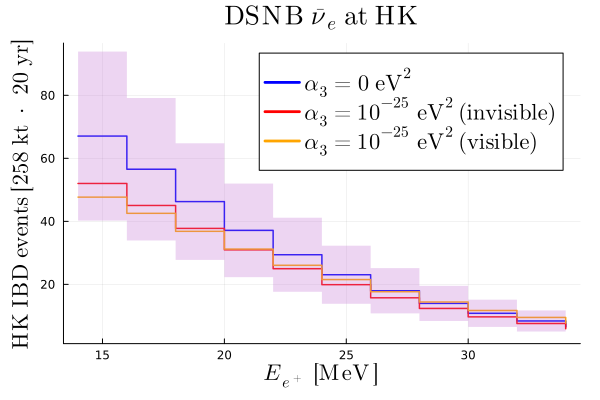

In [451]:
plot(es_grid_max,
     [events_HKIBD_nodecay_IO events_HKIBD_vdecay_25_IO_daughter3_f21 events_HKIBD_vdecay_25_IO_daughter3_f41],
     seriestype=:step,
     c=[:blue :red :orange :brown :black],
     lw=1.5,
     ls=[:solid :solid :solid],
     label=[L"\alpha_3 = 0~\mathrm{eV^2}" L"\alpha_3 = 10^{-25}~\mathrm{eV^2~(invisible)}" L"\alpha_3 = 10^{-25}~\mathrm{eV^2~(visible)}"],
     title=L"\mathrm{DSNB~}\bar{\nu}_e~\mathrm{at~HK}",
     ylabel=L"\mathrm{HK~IBD~events}~[\mathrm{258~kt~\cdot~20~yr}]",
     xlabel=L"E_{e^+}~\mathrm{[MeV]}",
     xguidefontsize=15,
     yguidefontsize=15,
     titlefontsize=18,
     legendfontsize=15,
     margins=3Plots.mm
)
plot!(es_grid_max,
     events_HKIBD_nodecay_IO_low,
     alpha=0,
     fillrange = events_HKIBD_nodecay_IO_high,
     seriestype=:step,
     fillalpha=0.3,
     label=false
)